In [1]:
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
import cv2

# add the path to my packages to system paths so they can be imported
import sys
# sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import my_similarity_graph_eff_test as sg

In [2]:
# load input data
data_path = '../../data/original_files/'

input_data = scipy.io.loadmat(data_path + 'salamanderRGCdata_long_fish_movie.mat')

In [3]:
frames = input_data['frames']
binned_data = input_data['binned_data']

In [4]:
def show_random_frames(frames, nframes, seed=None):
    assert(len(frames) >= nframes)
    
    if seed is not None:
        np.random.seed(seed)
    
    plt.figure(figsize = (15, nframes))
    
    for i in range(nframes):
        ind = np.random.randint(0,len(frames))
        plt.subplot(-(nframes//-3),3,i+1)
        plt.imshow(frames[ind], cmap='gray')
        plt.axis("off")
        plt.axis("equal")

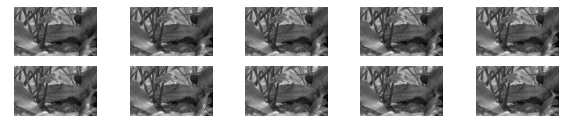

In [5]:
def show_consecutive_frames(frames, st_frame, nframes):
    assert(len(frames) >= nframes)
    
    plt.figure(figsize = (10, nframes//5))
    
    for ind in range(st_frame, st_frame+nframes):
        plt.subplot(-(nframes//-5),5,ind-st_frame+1)
        plt.imshow(frames[ind], cmap='gray')
        plt.axis("off")
        plt.axis("equal")

show_consecutive_frames(frames, st_frame=100, nframes=10)

In [6]:
# denoise all frames using the bilateral filter
bf_frames = []
for i in range(len(frames)):
    # Apply bilateral filter with d = 15,
    # sigmaColor = sigmaSpace = 75.
    bf_frames = bf_frames + [cv2.bilateralFilter(frames[i], 15, 20, 75)]
bf_frames = np.array(bf_frames)

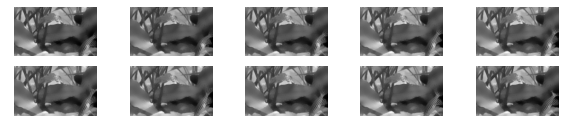

In [7]:
show_consecutive_frames(bf_frames, st_frame=100, nframes=10)

In [10]:
def simple_ft_norm(frames, batch_sz):
    """
    Compute sum of absolute differences between two consecutive frames over a larger set of frames.
    Then, normalize the output matrix.
    Batches are created using negative indices if necessary.
    
    Inputs: frames, batch_sz
    frames - NxHxW array of N frames of size (H, W)
    batch_sz - size of the set over which absolute differences are summed
    
    Outputs: fvn
    fvn - NxHxW array of normalized differences for N batches
    """
    
    N, height, width = frames.shape
    
    fvs = np.zeros((N, height, width))
    for index in range(N):
        # compute differences between frames
        for i in range(0, batch_sz-1):
            fvs[index] += np.abs(frames[index - i] - frames[index - i-1])

        # normalize
        norm = np.linalg.norm(fvs[index], ord='fro')
        fvs[index] = fvs[index] / (norm + 0.01)
        
    return fvs


In [11]:
def simple_ft_thresh(frames, batch_sz):
    """
    Compute sum of absolute differences between two consecutive frames over a larger set of frames.
    Then, normalize the output matrix.
    
    Inputs: frames, batch_sz
    frames - NxHxW array of N frames of size (H, W)
    batch_sz - size of the set over which absolute differences are summed
    
    Outputs: fvn
    fvn - MxHxW array of normalized differences for M batches (M = N-batch_sz+1)
    """
    
    N, height, width = frames.shape
    
    fvs = np.zeros((N, height, width))
    for index in range(N):
        # compute differences between frames
        for i in range(0, batch_sz-1):
            fvs[index] += np.abs(frames[index - i] - frames[index - i-1])

        # normalize
        norm = np.linalg.norm(fvs[index], ord='fro')
        fvs[index] = fvs[index] / (norm + 0.01)
        
        # treshold
        # threshold = (np.max(fvs[index]) - np.min(fvs[index])) / 2
        # threshold = np.median(fvs[index])
        threshold = np.percentile(fvs[index], 50)
        fvs[index] = (fvs[index] > threshold).astype(float)
        
    return fvs

In [12]:
# import matplotlib.animation as manimation

# # Define the meta data for the movie
# FFMpegWriter = manimation.writers['ffmpeg']
# metadata = dict(title='Movie Test', artist='Matplotlib',
#                 comment='a red circle following a blue sine wave')
# writer = FFMpegWriter(fps=15, metadata=metadata)

# # Update the frames for the movie
# fig = plt.figure()
# with writer.saving(fig, "writer_test.mp4", 100):
#     for i in range(500):
#         plt.imshow(bf_fvs[i])
#         writer.grab_frame()

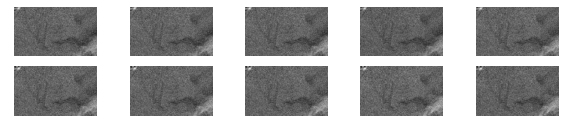

In [13]:
fvs = simple_ft_norm(frames, batch_sz=32)

show_consecutive_frames(fvs, st_frame=100, nframes=10)

In [16]:
# show_random_frames(fvs, nframes=10, seed=0)

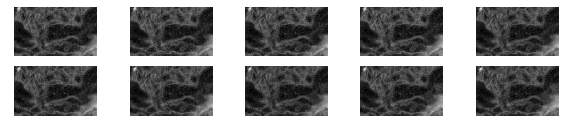

In [17]:
bf_fvs = simple_ft_norm(bf_frames, batch_sz=32)

show_consecutive_frames(bf_fvs, st_frame=100, nframes=10)

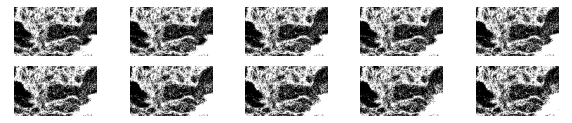

In [18]:
thresh_fvs = simple_ft_thresh(bf_frames, batch_sz=32)

show_consecutive_frames(thresh_fvs, st_frame=100, nframes=10)

# Use Similarity Graph Learning with These Features

In [28]:
# prepare training descriptors
train_dess = bf_fvs[::3,::5,::5].reshape(int(np.ceil(1141/3)), -1)

In [34]:
# prepare training labels
I_order = input_data['I_order'][0]
neuron = I_order[1]
trial = 1

train_lbls = binned_data[trial, :, neuron-1][::3]

In [35]:
print('# of training data points: ', len(train_dess))
print('# of features for each data point: ', train_dess.shape[1])
print('Neuron #:', neuron)

num_ones = np.sum(train_lbls == 1)
print('{} (= {:.2f}%) training points belong to class 1.'.format(num_ones, num_ones/len(train_dess)))

# of training data points:  381
# of features for each data point:  960
Neuron #: 35
11 (= 0.03%) training points belong to class 1.


In [36]:
# learning phase
sg_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
              'num_its':10, 'check_freq':1, 'print_checks':True, 'Theta0':None, \
              'force_all_its': True, 'threshold': 0.01}

B, sg_stats = sg.fit_graph(train_dess, train_lbls, sg_opt_params, mux=1, D=10, seed=0, edgesx=None)

entered sg.fit_graph. Here are the inputs:
dess
 [[0.00907536 0.00807353 0.01096901 ... 0.00805782 0.01207298 0.01307088]
 [0.00918146 0.00714732 0.01009127 ... 0.0081485  0.01119574 0.01322194]
 [0.00922961 0.00616506 0.01014058 ... 0.00818678 0.00922961 0.01129928]
 ...
 [0.00886729 0.00788546 0.00985683 ... 0.00887114 0.01281003 0.01182819]
 [0.00881999 0.00881999 0.01076169 ... 0.00785105 0.01176509 0.01176509]
 [0.00885942 0.00885173 0.00985149 ... 0.00787504 0.0118164  0.01181255]]
lbls
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

* for edge  (6, 231)
* wij =  0.9997812051234799
* for edge  (6, 70)
* wij =  0.9970367491919369
* for edge  (6, 97)
* wij =  0.9997800856078324
* for edge  (6, 131)
* wij =  0.9997665406838451
* for edge  (6, 176)
* wij =  0.9992210726579834
* for edge  (6, 225)
* wij =  0.9995193145391166
* for edge  (6, 69)
* wij =  0.997195816693178
* for edge  (6, 226)
* wij =  0.9994921211736825
* for edge  (6, 227)
* wij =  0.9995795880286593
* for edge  (7, 225)
* wij =  0.9995480995931173
* for edge  (7, 176)
* wij =  0.999262650542492
* for edge  (7, 226)
* wij =  0.9995225111138072
* for edge  (7, 227)
* wij =  0.9996041811798285
* for edge  (7, 231)
* wij =  0.9997846423005928
* for edge  (7, 69)
* wij =  0.9972858652357286
* for edge  (7, 102)
* wij =  0.9997951713834601
* for edge  (7, 131)
* wij =  0.9997710378164675
* for edge  (7, 97)
* wij =  0.9997861305010983
* for edge  (7, 56)
* wij =  0.9994565813199829
* for edge  (8, 226)
* wij =  0.9996360027550545
* for edge  (8, 69)
* wij = 

* for edge  (6, 131)
* wij =  0.0
* for edge  (6, 176)
* wij =  0.0
* for edge  (6, 225)
* wij =  0.0
* for edge  (6, 69)
* wij =  0.0
* for edge  (6, 226)
* wij =  0.0
* for edge  (6, 227)
* wij =  0.0
* for edge  (7, 225)
* wij =  0.0
* for edge  (7, 176)
* wij =  0.0
* for edge  (7, 226)
* wij =  0.0
* for edge  (7, 227)
* wij =  0.0
* for edge  (7, 231)
* wij =  0.0
* for edge  (7, 69)
* wij =  0.0
* for edge  (7, 102)
* wij =  0.0
* for edge  (7, 131)
* wij =  0.0
* for edge  (7, 97)
* wij =  0.0
* for edge  (7, 56)
* wij =  0.0
* for edge  (8, 226)
* wij =  0.0
* for edge  (8, 69)
* wij =  0.0
* for edge  (8, 131)
* wij =  0.0
* for edge  (8, 70)
* wij =  0.0
* for edge  (8, 56)
* wij =  0.0
* for edge  (8, 176)
* wij =  0.0
* for edge  (8, 225)
* wij =  0.0
* for edge  (8, 227)
* wij =  0.0
* for edge  (8, 97)
* wij =  0.0
* for edge  (8, 231)
* wij =  0.0
* for edge  (9, 70)
* wij =  0.0
* for edge  (9, 102)
* wij =  0.0
* for edge  (9, 176)
* wij =  0.0
* for edge  (9, 97)
* w

 [[1462.16959684 1205.34226123  686.79142052 ...  -14.47719169
  1720.23947856 1150.16939618]
 [1205.34226123 1376.76769251 1029.28356154 ... -257.84463821
  1852.70856015 1163.33071777]
 [ 686.79142052 1029.28356154  934.18124589 ... -317.35554787
  1359.94541354  782.43593604]
 ...
 [ -14.47719169 -257.84463821 -317.35554787 ...  193.99715905
  -369.17891166 -165.76928906]
 [1720.23947856 1852.70856015 1359.94541354 ... -369.17891166
  2752.22387406 1682.33641192]
 [1150.16939618 1163.33071777  782.43593604 ... -165.76928906
  1682.33641192 1088.08431541]]
* for edge  (0, 102)
* wij =  0.0
* for edge  (0, 227)
* wij =  0.0
* for edge  (0, 70)
* wij =  0.0
* for edge  (0, 231)
* wij =  0.0
* for edge  (0, 176)
* wij =  0.0
* for edge  (0, 69)
* wij =  0.0
* for edge  (0, 225)
* wij =  0.0
* for edge  (0, 226)
* wij =  0.0
* for edge  (0, 97)
* wij =  0.0
* for edge  (0, 56)
* wij =  0.0
* for edge  (1, 227)
* wij =  0.0
* for edge  (1, 231)
* wij =  0.0
* for edge  (1, 97)
* wij =  0.

* for edge  (9, 176)
* wij =  0.0
* for edge  (9, 97)
* wij =  0.0
* for edge  (9, 227)
* wij =  0.0
* for edge  (9, 69)
* wij =  0.0
* for edge  (9, 56)
* wij =  0.0
* for edge  (9, 226)
* wij =  0.0
* for edge  (9, 131)
* wij =  0.0
* for edge  (9, 225)
* wij =  0.0
* for edge  (10, 56)
* wij =  0.0
* for edge  (10, 69)
* wij =  0.0
* for edge  (10, 70)
* wij =  0.0
* for edge  (10, 102)
* wij =  0.0
* for edge  (10, 131)
* wij =  0.0
* for edge  (10, 225)
* wij =  0.0
* for edge  (10, 231)
* wij =  0.0
* for edge  (11, 56)
* wij =  0.0
* for edge  (11, 70)
* wij =  0.0
* for edge  (11, 102)
* wij =  0.0
* drdM = 
 [[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]
* glr =  0.0
* mu tr(M) =  1755783.0498827712
* E =  1755783.0498827712
* exit sg.cnstr_glr
-----------------------------------------------
* function sg.cnstr_glr is called. Here are

* for edge  (6, 131)
* wij =  0.0
* for edge  (6, 176)
* wij =  0.0
* for edge  (6, 225)
* wij =  0.0
* for edge  (6, 69)
* wij =  0.0
* for edge  (6, 226)
* wij =  0.0
* for edge  (6, 227)
* wij =  0.0
* for edge  (7, 225)
* wij =  0.0
* for edge  (7, 176)
* wij =  0.0
* for edge  (7, 226)
* wij =  0.0
* for edge  (7, 227)
* wij =  0.0
* for edge  (7, 231)
* wij =  0.0
* for edge  (7, 69)
* wij =  0.0
* for edge  (7, 102)
* wij =  0.0
* for edge  (7, 131)
* wij =  0.0
* for edge  (7, 97)
* wij =  0.0
* for edge  (7, 56)
* wij =  0.0
* for edge  (8, 226)
* wij =  0.0
* for edge  (8, 69)
* wij =  0.0
* for edge  (8, 131)
* wij =  0.0
* for edge  (8, 70)
* wij =  0.0
* for edge  (8, 56)
* wij =  0.0
* for edge  (8, 176)
* wij =  0.0
* for edge  (8, 225)
* wij =  0.0
* for edge  (8, 227)
* wij =  0.0
* for edge  (8, 97)
* wij =  0.0
* for edge  (8, 231)
* wij =  0.0
* for edge  (9, 70)
* wij =  0.0
* for edge  (9, 102)
* wij =  0.0
* for edge  (9, 176)
* wij =  0.0
* for edge  (9, 97)
* w

* for edge  (0, 102)
* wij =  1.93391014151739e-201
* for edge  (0, 227)
* wij =  1.8327270313216452e-268
* for edge  (0, 70)
* wij =  1.9010918515212916e-140
* for edge  (0, 231)
* wij =  3.066730085302308e-228
* for edge  (0, 176)
* wij =  1.2592046418929424e-119
* for edge  (0, 69)
* wij =  1.1468054128745405e-142
* for edge  (0, 225)
* wij =  1.0794307970882069e-245
* for edge  (0, 226)
* wij =  2.048272150305508e-251
* for edge  (0, 97)
* wij =  1.0068203263197065e-205
* for edge  (0, 56)
* wij =  1.205939276237152e-83
* for edge  (1, 227)
* wij =  4.516172562546343e-274
* for edge  (1, 231)
* wij =  5.932748371784035e-233
* for edge  (1, 97)
* wij =  6.073827697382196e-209
* for edge  (1, 131)
* wij =  1.1470435986548598e-223
* for edge  (1, 69)
* wij =  2.830043661338524e-159
* for edge  (1, 70)
* wij =  5.889507076595256e-157
* for edge  (1, 102)
* wij =  2.27305704827616e-205
* for edge  (1, 56)
* wij =  1.8325979412681685e-91
* for edge  (1, 226)
* wij =  6.688194909654003e-2

* for edge  (0, 227)
* wij =  1.1635215900029366e-67
* for edge  (0, 70)
* wij =  1.1742235198205475e-35
* for edge  (0, 231)
* wij =  1.3233322253858605e-57
* for edge  (0, 176)
* wij =  1.8837535293109166e-30
* for edge  (0, 69)
* wij =  3.272445583504271e-36
* for edge  (0, 225)
* wij =  5.731901269424706e-62
* for edge  (0, 226)
* wij =  2.127389027905573e-63
* for edge  (0, 97)
* wij =  5.632977203916631e-52
* for edge  (0, 56)
* wij =  1.8635084225283644e-21
* for edge  (1, 227)
* wij =  4.609911966991039e-69
* for edge  (1, 231)
* wij =  8.77635096328347e-59
* for edge  (1, 97)
* wij =  8.82806692617147e-53
* for edge  (1, 131)
* wij =  1.8403269303263948e-56
* for edge  (1, 69)
* wij =  2.3064725161992375e-40
* for edge  (1, 70)
* wij =  8.76031528938781e-40
* for edge  (1, 102)
* wij =  6.904823535178766e-52
* for edge  (1, 56)
* wij =  2.0690300514577627e-23
* for edge  (1, 226)
* wij =  9.043306080201605e-65
* for edge  (1, 176)
* wij =  2.118834482326778e-31
* for edge  (2,

* for edge  (0, 227)
* wij =  1.8469009793496862e-17
* for edge  (0, 70)
* wij =  1.851133301594896e-09
* for edge  (0, 231)
* wij =  6.031387368337627e-15
* for edge  (0, 176)
* wij =  3.704725372893486e-08
* for edge  (0, 69)
* wij =  1.3449870672251417e-09
* for edge  (0, 225)
* wij =  4.89299391081558e-16
* for edge  (0, 226)
* wij =  2.1476412096380901e-16
* for edge  (0, 97)
* wij =  1.5405808617365245e-13
* for edge  (0, 56)
* wij =  6.570264297788674e-06
* for edge  (1, 227)
* wij =  8.239923088251378e-18
* for edge  (1, 231)
* wij =  3.0607544920657197e-15
* for edge  (1, 97)
* wij =  9.693182827288132e-14
* for edge  (1, 131)
* wij =  1.1647259331661238e-14
* for edge  (1, 69)
* wij =  1.232358517245253e-10
* for edge  (1, 70)
* wij =  1.7204019821299278e-10
* for edge  (1, 102)
* wij =  1.6210191519962028e-13
* for edge  (1, 56)
* wij =  2.132758589163779e-06
* for edge  (1, 226)
* wij =  9.751733127125213e-17
* for edge  (1, 176)
* wij =  2.1454789507167484e-08
* for edge  

* for edge  (5, 97)
* wij =  2.414039114134923e-07
* for edge  (5, 231)
* wij =  2.5793893644830938e-08
* for edge  (5, 69)
* wij =  4.436783487353851e-09
* for edge  (5, 225)
* wij =  5.5218695406507195e-09
* for edge  (5, 226)
* wij =  3.5605487666038993e-09
* for edge  (5, 176)
* wij =  5.4740388912841447e-05
* for edge  (5, 131)
* wij =  4.5963874808147895e-08
* for edge  (5, 102)
* wij =  2.176721849658844e-07
* for edge  (5, 227)
* wij =  1.0141899652688814e-09
* for edge  (5, 56)
* wij =  5.293438167888995e-05
* for edge  (6, 56)
* wij =  1.8107405040981567e-05
* for edge  (6, 231)
* wij =  2.6418681479076065e-08
* for edge  (6, 70)
* wij =  6.81594113674315e-10
* for edge  (6, 97)
* wij =  2.642230338977275e-07
* for edge  (6, 131)
* wij =  4.482069724466746e-08
* for edge  (6, 176)
* wij =  3.829918000028085e-05
* for edge  (6, 225)
* wij =  5.580670967386721e-09
* for edge  (6, 69)
* wij =  5.526624020213492e-10
* for edge  (6, 226)
* wij =  3.639965940473423e-09
* for edge  

* for edge  (8, 70)
* wij =  1.7885167465438734e-10
* for edge  (8, 56)
* wij =  1.182479450272572e-05
* for edge  (8, 176)
* wij =  6.058107547522933e-05
* for edge  (8, 225)
* wij =  2.049130453403637e-08
* for edge  (8, 227)
* wij =  4.5433940961393384e-09
* for edge  (8, 97)
* wij =  9.343666275102906e-07
* for edge  (8, 231)
* wij =  9.416958496364326e-08
* for edge  (9, 70)
* wij =  2.5821927409182056e-10
* for edge  (9, 102)
* wij =  1.3477004787800941e-06
* for edge  (9, 176)
* wij =  9.826266619768107e-05
* for edge  (9, 97)
* wij =  1.8732341990971943e-06
* for edge  (9, 227)
* wij =  9.830146343926587e-09
* for edge  (9, 69)
* wij =  2.1226227109121768e-10
* for edge  (9, 56)
* wij =  1.7074548404708248e-05
* for edge  (9, 226)
* wij =  2.8946438775219576e-08
* for edge  (9, 131)
* wij =  3.0293857300888267e-07
* for edge  (9, 225)
* wij =  4.2406000314145266e-08
* for edge  (10, 56)
* wij =  3.3835576909148475e-05
* for edge  (10, 69)
* wij =  4.650291354699249e-10
* for ed

* for edge  (0, 227)
* wij =  3.175515658017523e-07
* for edge  (0, 70)
* wij =  6.723855272911945e-05
* for edge  (0, 231)
* wij =  1.497876555138325e-06
* for edge  (0, 176)
* wij =  0.00022673846909770283
* for edge  (0, 69)
* wij =  5.8239066125196684e-05
* for edge  (0, 225)
* wij =  1.0744135459604093e-06
* for edge  (0, 226)
* wij =  8.120945586035171e-07
* for edge  (0, 97)
* wij =  4.507747059905291e-06
* for edge  (0, 56)
* wij =  0.00040150437375063587
* for edge  (1, 227)
* wij =  2.6379747835151717e-07
* for edge  (1, 231)
* wij =  1.2711269521834258e-06
* for edge  (1, 97)
* wij =  4.071604172287079e-06
* for edge  (1, 131)
* wij =  1.629507033980569e-06
* for edge  (1, 69)
* wij =  2.72314804866274e-05
* for edge  (1, 70)
* wij =  3.157027954650179e-05
* for edge  (1, 102)
* wij =  2.301820765271226e-06
* for edge  (1, 56)
* wij =  0.00026767130337586233
* for edge  (1, 226)
* wij =  6.769250429283571e-07
* for edge  (1, 176)
* wij =  0.00019094844099365961
* for edge  (

* for edge  (0, 227)
* wij =  8.266052472905194e-07
* for edge  (0, 70)
* wij =  3.054153465401894e-05
* for edge  (0, 231)
* wij =  1.933995298817819e-06
* for edge  (0, 176)
* wij =  2.8689851483347803e-06
* for edge  (0, 69)
* wij =  2.7292289948727018e-05
* for edge  (0, 225)
* wij =  2.4977696440124506e-06
* for edge  (0, 226)
* wij =  2.2593334873621686e-06
* for edge  (0, 97)
* wij =  3.886898036676451e-06
* for edge  (0, 56)
* wij =  4.447573235217778e-05
* for edge  (1, 227)
* wij =  5.329505618593692e-07
* for edge  (1, 231)
* wij =  1.2591384949440566e-06
* for edge  (1, 97)
* wij =  2.653459781321995e-06
* for edge  (1, 131)
* wij =  7.88488404726145e-07
* for edge  (1, 69)
* wij =  1.2485991564526965e-05
* for edge  (1, 70)
* wij =  1.4014825507387716e-05
* for edge  (1, 102)
* wij =  1.9706233299436383e-07
* for edge  (1, 56)
* wij =  2.45236880482645e-05
* for edge  (1, 226)
* wij =  1.4828832788095618e-06
* for edge  (1, 176)
* wij =  1.7051293038425971e-06
* for edge  

* for edge  (5, 231)
* wij =  1.7610447753549202e-05
* for edge  (5, 69)
* wij =  1.1750666380155783e-05
* for edge  (5, 225)
* wij =  2.242462730726155e-05
* for edge  (5, 226)
* wij =  2.103217332229797e-05
* for edge  (5, 176)
* wij =  1.3856145491580717e-05
* for edge  (5, 131)
* wij =  1.1212145838604131e-05
* for edge  (5, 102)
* wij =  3.507921486548932e-06
* for edge  (5, 227)
* wij =  9.527980525939694e-06
* for edge  (5, 56)
* wij =  5.213007745634355e-05
* for edge  (6, 56)
* wij =  3.1994017299031916e-05
* for edge  (6, 231)
* wij =  1.4969138326559244e-05
* for edge  (6, 70)
* wij =  6.1239188509649225e-06
* for edge  (6, 97)
* wij =  3.079386826247446e-05
* for edge  (6, 131)
* wij =  9.35008771491796e-06
* for edge  (6, 176)
* wij =  1.0318421075200087e-05
* for edge  (6, 225)
* wij =  1.9136498504643863e-05
* for edge  (6, 69)
* wij =  5.56002496833317e-06
* for edge  (6, 226)
* wij =  1.8025618329336498e-05
* for edge  (6, 227)
* wij =  8.209023565046055e-06
* for edge

* for edge  (8, 56)
* wij =  3.729173507400461e-05
* for edge  (8, 176)
* wij =  1.6273826093518805e-05
* for edge  (8, 225)
* wij =  3.4313562634783125e-05
* for edge  (8, 227)
* wij =  1.5422792787593226e-05
* for edge  (8, 97)
* wij =  5.696922778224807e-05
* for edge  (8, 231)
* wij =  2.7262174546343237e-05
* for edge  (9, 70)
* wij =  7.4061187944328824e-06
* for edge  (9, 102)
* wij =  9.14999035850397e-06
* for edge  (9, 176)
* wij =  2.6009970622908956e-05
* for edge  (9, 97)
* wij =  9.139164621431278e-05
* for edge  (9, 227)
* wij =  2.500532962484722e-05
* for edge  (9, 69)
* wij =  6.7719391927438645e-06
* for edge  (9, 56)
* wij =  5.554986855540521e-05
* for edge  (9, 226)
* wij =  5.174791289781514e-05
* for edge  (9, 131)
* wij =  2.776482366737549e-05
* for edge  (9, 225)
* wij =  5.4351109351658325e-05
* for edge  (10, 56)
* wij =  0.00010835288604084145
* for edge  (10, 69)
* wij =  1.2738573422475551e-05
* for edge  (10, 70)
* wij =  1.3869844523597475e-05
* for ed

<Figure size 432x288 with 0 Axes>

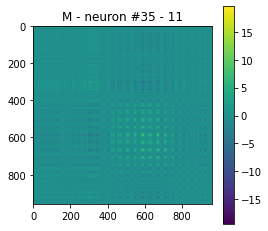

In [37]:
# path to save files
path = 'SimpleFeaturesNorm/'

M = B.T @ B

plt.figure()
sg.display_matrix(M, 'M - neuron #{} - {}'.format(neuron, num_ones))
# plt.savefig(path+'Mdiag/'+str(num_ones)+'_neuron_'+str(neuron)+'.png')

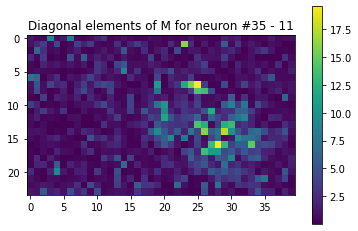

In [38]:
Mdiag = np.array([M[i,i] for i in range(len(M))])

# plot diagonal elements of M in the shape of input images
plt.figure()
plt.imshow(Mdiag.reshape(24,40))
plt.title('Diagonal elements of M for neuron #{} - {}'.format(neuron, num_ones))
plt.colorbar()
# plt.savefig(path+'M/'+str(num_ones)+'_neuron_'+str(neuron)+'.png')

# Save diagonal elements of $M^*$ for various neurons

entered sg.fit_graph. Here are the inputs:
dess
 [[0. 0. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
lbls
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
opt_params
 {'epsilon0': 1, 'epsilon_d

<Figure size 640x480 with 0 Axes>

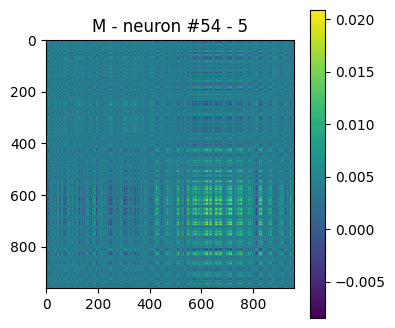

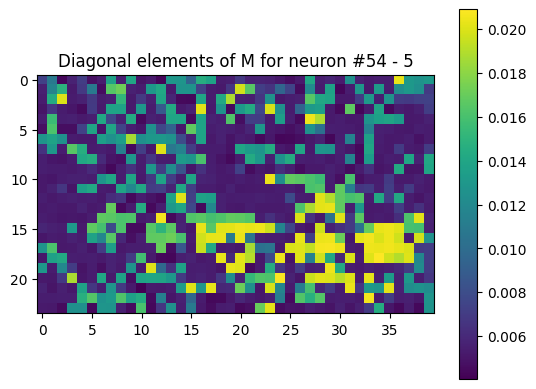

<Figure size 640x480 with 0 Axes>

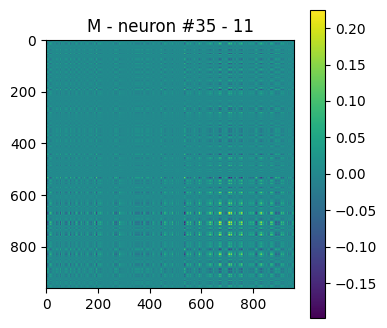

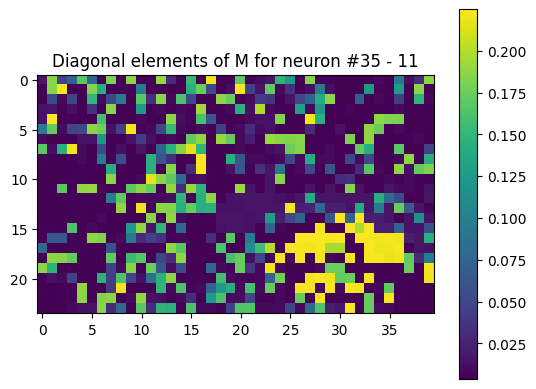

<Figure size 640x480 with 0 Axes>

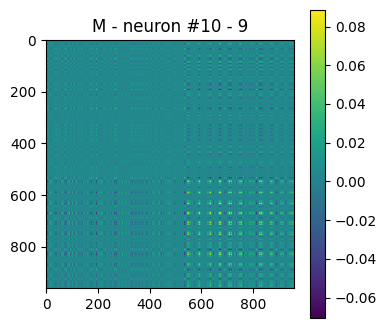

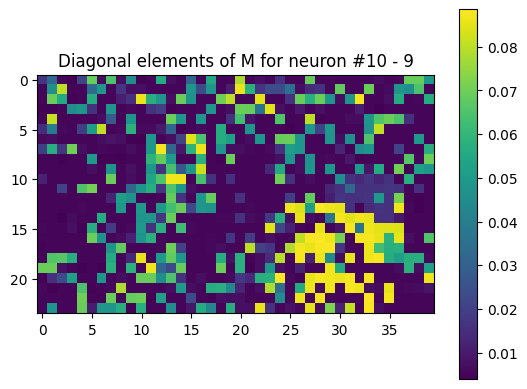

<Figure size 640x480 with 0 Axes>

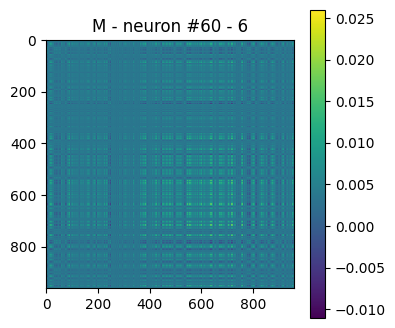

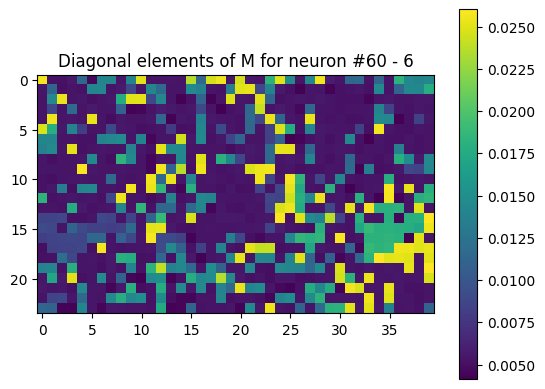

<Figure size 640x480 with 0 Axes>

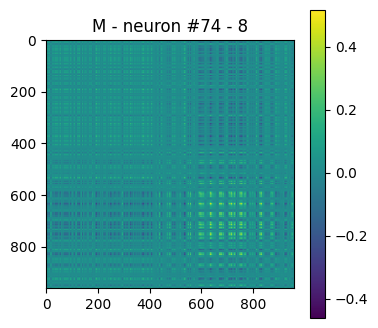

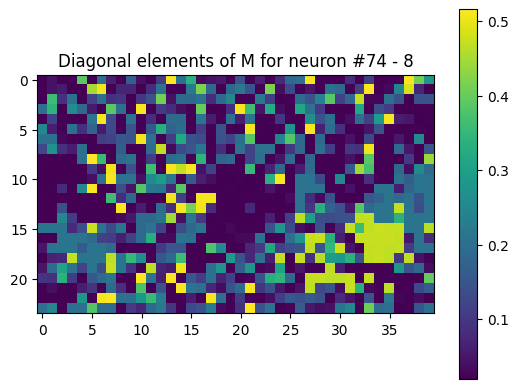

In [257]:
for i in range(113):
    neuron = I_order[i]
    train_lbls = binned_data[trial, :, neuron-1][::3]
    num_ones = np.sum(train_lbls == 1)
    
    B, sg_stats = sg.fit_graph(train_dess, train_lbls, sg_opt_params, mux=1, D=10, seed=0, edgesx=None)
    
    M = B.T @ B
    plt.figure()
    sg.display_matrix(M, 'M - neuron #{} - {}'.format(neuron, num_ones))
    plt.savefig(path+'Mdiag/'+str(num_ones)+'_neuron_'+str(neuron)+'.png')
    
    Mdiag = np.array([M[i,i] for i in range(len(M))])

    # plot diagonal elements of M in the shape of input images
    plt.figure()
    plt.imshow(Mdiag.reshape(24,40))
    plt.title('Diagonal elements of M for neuron #{} - {}'.format(neuron, num_ones))
    plt.colorbar()
    plt.savefig(path+'M/'+str(num_ones)+'_neuron_'+str(neuron)+'.png')
    